In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from imageio import imread
from skimage.transform import resize
import cv2
import datetime
import os
%matplotlib inline

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
# D:\Jupyter_Notebooks\Gesture Recognition\Project_data\Project_data
val_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
batch_size = 16

In [5]:
#generator function
def generator(source_path, folder_list, batch_size,img_idx,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx#np.arange(0,30)#create a list of image numbers you want to use for a particular video
    x=len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
       # print(len(t),len(source_path))
        num_batches =len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures
                    cropped=image[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0]=image_resized[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1]=image_resized[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2]=image_resized[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_batch_size=len(t)%batch_size
        if remaining_batch_size!=0:
            batch_size=remaining_batch_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures
                    cropped=image[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(y,z,3))
                    
                    batch_data[folder,idx,:,:,0]=image_resized[:,:,0]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1]=image_resized[:,:,1]/255.0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2]=image_resized[:,:,2]/255.0 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Source path =  datasets/Project_data/train ; batch size = 32


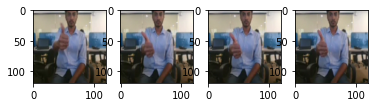

In [6]:
#testing generator function
y=120
z=120
img_idx=np.arange(0,30,1)
#[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
batch_size=32

train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
#np.arange(0,30,1)
g=generator(train_path, train_doc, batch_size,img_idx,y,z)
batch_data, batch_labels=next(g)
# print(batch_labels)
fig, axes = plt.subplots(nrows=1, ncols=4)
axes[0].imshow(batch_data[17,0,:,:,:])   
axes[1].imshow(batch_data[17,2,:,:,:])   
axes[2].imshow(batch_data[17,4,:,:,:])   
axes[3].imshow(batch_data[17,6,:,:,:])   

### Modelling

In [7]:
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU,LSTM, Dropout, Flatten,Conv2D, BatchNormalization, Activation, Conv3D, MaxPooling3D,MaxPooling2D,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [8]:
#function for training models
def training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs):
    
    curr_dt_time = datetime.datetime.now()
    train_path = 'datasets/Project_data/train'
    val_path = 'datasets/Project_data/train'
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    num_epochs = num_epochs# choose the number of epochs
    print ('# epochs =', num_epochs)
        
    #Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
    train_generator = generator(train_path, train_doc, batch_size,img_idx,y,z)
    val_generator = generator(val_path, val_doc, batch_size,img_idx,y,z)
    
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    
    #The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    #Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
    new_model=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

    return new_model


In [9]:
#function for plotting
def plots(model,epochs):
    ### Training and Val set Accuracies
    acc = model.history['categorical_accuracy']
    val_acc = model.history['val_categorical_accuracy']
    ### Training and Val set Accuracies
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# 3D CNN Modelling

3D CNN model with image size as 120x120<br>
epochs = 20<br>
batch_size = 32<br>
batch_normalization & dropouts included

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 17, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 17, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 60, 60, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 60, 60, 32)     8224      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 30, 30, 32)    0         
 3D)                                                             
                                                        

2022-06-12 15:53:09.855130: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-12 15:53:09.855198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/20


2022-06-12 15:53:16.531628: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.8340 - categorical_accuracy: 0.2293Source path =  datasets/Project_data/train ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59490, saving model to model_init_2022-06-1215_53_09.955704/model-00001-1.83398-0.22926-1.59490-0.24434.h5
21/21 [==============================] - 195s 10s/step - loss: 1.8340 - categorical_accuracy: 0.2293 - val_loss: 1.5949 - val_categorical_accuracy: 0.2443 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2123 - categorical_accuracy: 0.5155
Epoch 00002: val_loss improved from 1.59490 to 1.51467, saving model to model_init_2022-06-1215_53_09.955704/model-00002-1.21227-0.51553-1.51467-0.43478.h5
21/21 [==============================] - 143s 7s/step - loss: 1.2123 - categorical_accuracy: 0.5155 - val_loss: 1.5147 - val_categorical_accuracy: 0.4348 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.0768 - categorical_accura

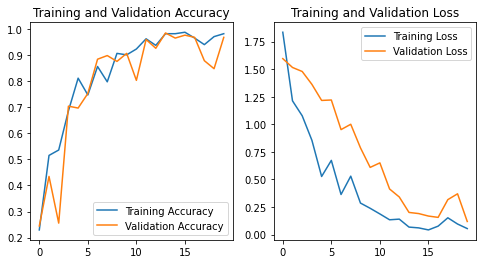

In [10]:
### Training Parameters
y=120
z=120
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
### 3D conv Lavers
model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
model.add(Conv3D(32, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
### Flattening the CNN's
model.add(Flatten())
### Adding Dense Connections
model.add(Dense(256))
model.add(Activation('relu'))
### Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model,num_epochs)

### Observation

here we see that our training as well as our validation accuracy has gone up. we can see major fluctuations. let us now try to get rid of batchnormalozation and add a few dropouts <br>
rerun the process with 140x140 image size

## 3D CNN Modelling
3D CNN model with image size as 140x140 pixels <br>
epochs = 20 <br>
batch_size = 40<br>
dropout included to handle overfitting

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 17, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 70, 70, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 70, 70, 32)     8224      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 4, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 4, 35, 35, 64)     16448     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 2, 17, 17, 64)   

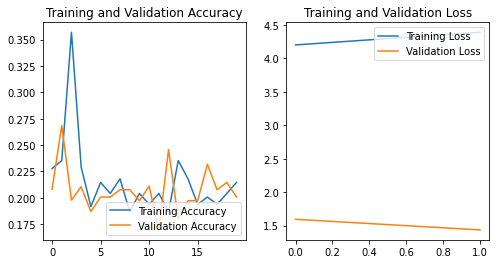

In [20]:
### Training Parameters
y=140
z=140
img_idx=[0,1,2,4,6,8,10,12,14,15,17,19,20,22,24,26,28]
x=len(img_idx)
num_epochs=20
batch_size = 40

input_shape = (x,y,z,3)
model = Sequential()
### 3D conv Lavers
model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(32, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
### Flattening the CNN's
model.add(Flatten())
### Adding Dense Connections
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))
### Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))
model.add(Dropout(0.2))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model,num_epochs)

### Observation

looks like our model is underfitting here. our train and val accuricies seem to be very low. in the next iternation let's not add dropouts to our model. also we will not include batch normalization to our final model

# 3D CNN Modelling
3D CNN model with image size as 140x140 pixels<br>
epochs = 20<br>
batch_size = 32<br>
we have reduced the number of frames to 10 only

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27] 10
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 10, 140, 140, 32)  2624      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 5, 70, 70, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 5, 70, 70, 32)     8224      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 2, 35, 35, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 2, 35, 35, 64)     16448     
                                                                 
 max_pooling3d

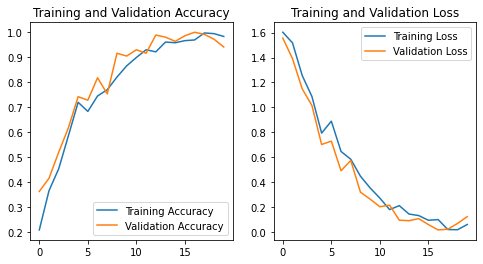

In [21]:
### Training Parameters
y=140
z=140
img_idx=[i for i in range(0,30,3)]
print(img_idx, len(img_idx))
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
### 3D conv Lavers
model.add(Conv3D(32, kernel_size=(3,3,3),strides=(1,1,1), padding='same', activation='leaky_relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(32, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model.add(Conv3D(64, kernel_size=(2,2,2),strides=(1,1,1), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
### Flattening the CNN's
model.add(Flatten())
### Adding Dense Connections
model.add(Dense(256))
model.add(Activation('relu'))
### Output Layer
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model, num_epochs)

### Observation

In 3D CNN we have got the best results, with only 10 frames passing in each video.<br>
<b> Train Accuracy = 98% </b><br>
<b> Val Accuracy = 94% </br><br>
Also, if we see our graph in every epoch the training and val accuracy and loss seems to be constant. this is the best model we have achieved so far for our dataset

# CNN + RNN

1. we will use transfer learning here and try with 2 different RNN networks (GRU & LSTM)
2. for transfer learning we will use RESNET and Xception 

# RESNET + GRU

In [25]:
from tensorflow.keras.applications import ResNet50V2,ResNet50
from keras.layers import TimeDistributed

resnet + gru with dropouts applied

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27] 10
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 5, 5, 2048)   23564800  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 2, 2, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 8192)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 10, 64)            1585536   
                                                                 
 gru_1 (GRU)                 (None, 10, 32)            9408      
              

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - 136s 6s/step - loss: 1.6089 - categorical_accuracy: 0.2926 - val_loss: 1.4327 - val_categorical_accuracy: 0.4811 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4326 - categorical_accuracy: 0.3954
Epoch 00002: val_loss improved from 1.43273 to 1.24932, saving model to model_init_2022-06-1213_27_24.085400/model-00002-1.43262-0.39545-1.24932-0.59213.h5
21/21 [==============================] - 94s 5s/step - loss: 1.4326 - categorical_accuracy: 0.3954 - val_loss: 1.2493 - val_categorical_accuracy: 0.5921 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.3299 - categorical_accuracy: 0.4286
Epoch 00003: val_loss improved from 1.24932 to 1.09859, saving model to model_init_2022-06-1213_27_24.085400/model-00003-1.32990-0.42857-1.09859-0.58234.h5
21/21 [==============================] - 80s 4s/step - loss: 1.3299 - categorical_accuracy: 0.4286 - val_loss: 1.0986 - val_categorical_accurac

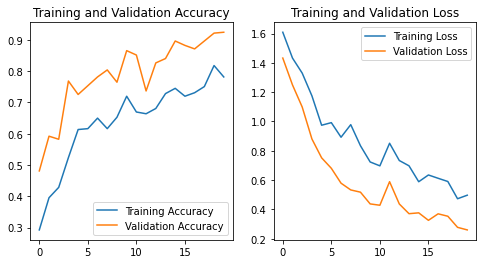

In [26]:
### Training Parameters
y=140
z=140
img_idx=[i for i in range(0,30,3)]
print(img_idx, len(img_idx))
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
resnet=ResNet50V2(weights='imagenet', include_top=False,input_shape=(y,z,3))
resnet.trainable=False
### Adding Resnet
model.add(TimeDistributed(resnet, input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
### Adding GRU layers
model.add(GRU(64,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.50))
model.add(Dense(16))
model.add(Dropout(0.50))
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model, num_epochs)

# Observation

There seems to be a lot of varinace in our train and val accuracy and loss, although our line at every epoch follows a similar trend(as per the graph) but there seems to be overfitting happening here.

# RESNET + GRU

have changed some parameters and have modified some layers and dropouts from the previous model

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] 15
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 15, 5, 5, 2048)   23564800  
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 2, 2, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 8192)         0         
 tributed)                                                       
                                                                 
 gru_4 (GRU)                 (None, 15, 64)            1585536   
                                                                 
 gru_5 (GRU)                 (None, 15, 32)            9408  

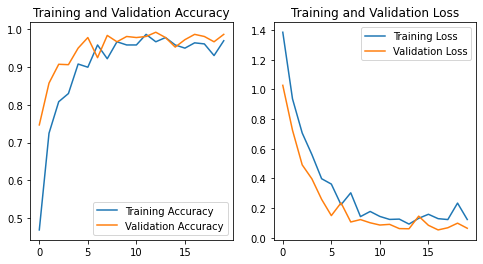

In [27]:
### Training Parameters
y=140
z=140
img_idx = [i for i in range(0,30,2)]
print(img_idx, len(img_idx))
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
resnet=ResNet50V2(weights='imagenet', include_top=False,input_shape=(y,z,3))
resnet.trainable=False
### Adding Resnet
model.add(TimeDistributed(resnet, input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
### Adding GRU layers
model.add(GRU(64,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(16))
model.add(Dense(16))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model, num_epochs)

### Observation

With the change in dropout values, we have achieved far better results.<br>
<b> Train Accuracy - 96%</b><br>
<b> Val Accuracy - 98%</b><br>
till now this is the best model we have achieved

# Xception + GRU

keeping the network same, here for transfer learning we are using Xception instead of resnet

In [28]:
from tensorflow.keras.applications.xception import Xception

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] 15
83697664/83683744 [==============================] - 2s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 15, 5, 5, 2048)   20861480  
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 2, 2, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 8192)         0         
 tributed)                                                       
                                                                 
 gru_7 (GRU)                 (None, 15, 64)            1585536   
                                                              

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - 224s 11s/step - loss: 1.7225 - categorical_accuracy: 0.2519 - val_loss: 1.5131 - val_categorical_accuracy: 0.2549 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4559 - categorical_accuracy: 0.3810
Epoch 00002: val_loss improved from 1.51308 to 1.30088, saving model to model_init_2022-06-1214_28_16.173016/model-00002-1.45592-0.38095-1.30088-0.51760.h5
21/21 [==============================] - 143s 7s/step - loss: 1.4559 - categorical_accuracy: 0.3810 - val_loss: 1.3009 - val_categorical_accuracy: 0.5176 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2531 - categorical_accuracy: 0.5222
Epoch 00003: val_loss improved from 1.30088 to 1.08002, saving model to model_init_2022-06-1214_28_16.173016/model-00003-1.25306-0.52225-1.08002-0.63007.h5
21/21 [==============================] - 117s 6s/step - loss: 1.2531 - categorical_accuracy: 0.5222 - val_loss: 1.0800 - val_categorical_accu

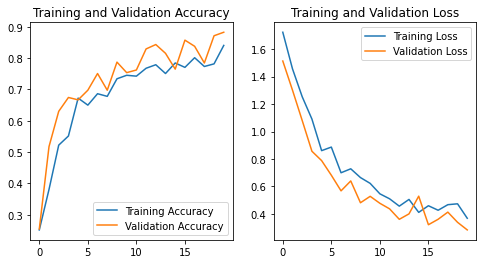

In [29]:
### Training Parameters
y=140
z=140
img_idx=[i for i in range(0,30,2)]
print(img_idx, len(img_idx))
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
xception=Xception(weights='imagenet', include_top=False,input_shape=(y,z,3))
xception.trainable=False
### Adding Resnet
model.add(TimeDistributed(xception, input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
### Adding GRU layers
model.add(GRU(64,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(16))
model.add(Dense(16))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model, num_epochs)

### Observation

Our Graph looks good here, but still could not achieve accuracy as much as RESNET+GRU, we got pretty good results here but we have a beter model in place

# RESNET + LSTM

As we got good results with RESNET + GRU, lets try the same network and replace GRU with LSTM in the below network

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] 15
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 5, 5, 2048)   23564800  
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 8192)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 15, 64)            2113792   
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            12416

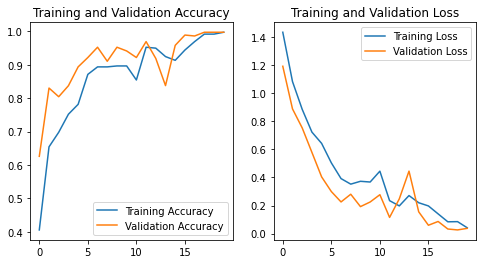

In [30]:
### Training Parameters
y=140
z=140
img_idx = [i for i in range(0,30,2)]
print(img_idx, len(img_idx))
x=len(img_idx)
num_epochs=20
batch_size = 32

input_shape = (x,y,z,3)
model = Sequential()
resnet=ResNet50V2(weights='imagenet', include_top=False,input_shape=(y,z,3))
resnet.trainable=False
### Adding Resnet
model.add(TimeDistributed(resnet, input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
### Adding GRU layers
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16))
model.add(Dense(16))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
new_model = training(model,train_doc, val_doc, batch_size,img_idx,y,z,num_epochs)
plots(new_model, num_epochs)

### Observation

this is by far the best model we have achieved when we talk in terms of accuracy and loss.<br>
<b>Train Accuracy - 99%</b><br>
<b>Val Accuracy - 999%</b><br>

## Conclusion

* 3DCNN
    * 3DCNN gave us exceptional results when we used only 10/30 images from a video to train our model.
    * 3DCNN tend to gave better results when we removd dropouts, when we added dropouts to the model the accuracy dropped miserably leading to an underfitting model.
* Transfer Learning
    * RESNET+GRU gave us good results, when we reduced the number of dropouts in this model we observed thatthe accuracy went up and we acheived around 96% accuracy on the val data
    * XCEPTION+GRU gave us good results but <u>3DCNN</u> and <u>RESNET+GRU</u> proved to be better models for our dataset.
    * RESNET+LSTM proved out be the best model for us, as the accuracy we achieved on the training and val set was approximately 99% on both.